In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
model_dir = '/kuacc/users/mali18/dicomogan/logs/_triple_modulation_l2_with_mean_embed2022-10-15T19-19-34'
img_root = '/kuacc/users/abond19/datasets/aligned_fashion_dataset'
inverted_img_root =  '/kuacc/users/abond19/datasets/inverted_fashion_dataset'
inversion_root =  '/kuacc/users/abond19/datasets/w+_fashion_dataset/fashion/PTI/'

In [3]:
device = 'cuda'

In [4]:
tgt_desc = [
    'Blue T-shirts Made from rayon-nylon blend Round neckline Slogan printed front Pearl detail Short sleeves Regular fit',
    'Dresses Shift White One shoulder design Made from cotton Lace detailed ruffled yoke Regular fit Mini length Sleeveless',
#     'Multi Leggings Made from poly-lycra blend Elasticated waistband All over crane print Tape detail at sides Bodycon fit',
#     'a short white Sleeveless Dresses made from cotton',
]

In [5]:
videos = [
    '8c110571',
    '2c111960',
    '8c110147'
]

In [6]:
from experiments_utils import *
model = load_model_from_dir(model_dir).to(device)

Restored from /kuacc/users/mali18/dicomogan/logs/_triple_modulation_l2_with_mean_embed2022-10-15T19-19-34/VideoManipulation/_triple_modulation_l2_with_mean_embed2022-10-15T19-19-34/checkpoints/epoch=152-step=114596.ckpt


In [7]:
def save_gif(video, save_path):
    # Assuming that the current shape is T x C x H x W
    import imageio
    with imageio.get_writer(f'{save_path}.gif', mode='I') as writer:
        for img in video:
            writer.append_data(img)

In [8]:
# load images
import os
import torch 
from PIL import Image
import torchvision.transforms as transforms
IMG_EXTENSIONS = ['.png', '.PNG']
TXT_EXTENSIONS = ['.txt']

crop = None
size = (256, 192)
trans_list = []
if crop is not None:
    trans_list.append(transforms.CenterCrop(tuple(crop)))
if size is not None:
    trans_list.append(transforms.Resize(tuple(size)))
trans_list.append(transforms.ToTensor())
img_transform=transforms.Compose(trans_list)

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def is_text_file(filename):
    return any(filename.endswith(extension) for extension in TXT_EXTENSIONS)

def get_image(img_path):
    img = Image.open(img_path).convert('RGB')
    return img

def get_inversion(inversion_path):
    w_vector = torch.load(inversion_path, map_location='cpu')
    assert (w_vector.shape == (1, 18, 512)), "Inverted vector has incorrect shape"
    return w_vector

def load_video(vid_path):
    images, inversions, sampleT, inversion_imgs = [], [], [], [] 
    fname = vid_path
    for f in sorted(os.listdir(os.path.join(img_root, fname)))[5:25]:
        if is_image_file(f):
            imname = f[:-4]
            images.append(img_transform(get_image(os.path.join(img_root, fname, f))))
            inversion_imgs.append(img_transform(get_image(os.path.join(inverted_img_root, fname, f))))
            inversions.append(get_inversion(os.path.join(os.path.join(inversion_root, fname, imname + ".pt"))))
            sampleT.append(int(imname))
    
    return torch.stack(images).to(device), torch.cat(inversions, 0).to(device), torch.Tensor(sampleT).to(device), torch.stack(inversion_imgs).to(device)

In [9]:
from torch import nn
def forward_w_color(self, videos, inversions, sampleT, input_desc):
    """
    return a dictionary of tensors in the range [-1, 1]
    """
    ret = dict()

    vid = videos # B x T x ch x H x W -- range [0, 1]
    input_desc = input_desc 
    sampleT = sampleT 
    
    bs, T, ch, height, width = vid.size()
    n_frames = T
    ts = (sampleT)*0.01
    ts = ts - ts[0] 


    video_sample = vid # B x T x C x H x W 
    video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
    video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
    video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

    # inversions reshape
    inversions_bf = inversions # B, T x n_layers x D
    bs, T, n_channels, dim = inversions_bf.shape
    inversions_tf = inversions_bf.permute(1, 0, 2, 3)
    inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

    # downsample res for vae
    vid_rs_full = nn.functional.interpolate(video_sample, scale_factor=0.5, mode="bicubic", align_corners=False, recompute_scale_factor=True)
    vid_rs = vid_rs_full.view(n_frames, bs, ch, int(height*0.5),int(width*0.5) )
    vid_rs = vid_rs.permute(1,0,2,3,4) #  B x T x C x H//2 x W//2

    # encode text
    txt_feat = self.clip_encode_text(input_desc)  # B x D
    txt_feat = txt_feat.unsqueeze(0).repeat(n_frames,1,1)
    txt_feat = txt_feat.view(bs * n_frames, -1)  # T*B x D

    # vae encode frames
    zs, zd, mu_logvar_s, mu_logvar_d = self.bVAE_enc(vid_rs, ts)
    z_vid = torch.cat((zs, zd), 1) # T*B x D 

    muT, logvarT = self.text_enc(txt_feat)
    zT = self.reparametrize(muT, logvarT) # T*B x D 

    # generate with mathching text
    latentw = self.mapping(z_vid[:,self.vae_cond_dim:])
    
    frame_rep = torch.cat((latentw, txt_feat), -1) # T*B x D1+D2

    # predict latents delta
    w_latents = inversions + self.delta_inversion_weight * self.style_mapper(inversions, frame_rep)
    ret = self.stylegan_G(w_latents) / 2 + 0.5 
    ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
    return ret



In [10]:
from torch import nn
def forward_from_mean(self, videos, inversions, sampleT, input_desc):
    """
    return a dictionary of tensors in the range [-1, 1]
    """
    ret = dict()

    vid = videos # B x T x ch x H x W -- range [0, 1]
    input_desc = input_desc 
    sampleT = sampleT 
    
    bs, T, ch, height, width = vid.size()
    n_frames = T
    ts = (sampleT)*0.01
    ts = ts - ts[0] 


    video_sample = vid # B x T x C x H x W 
    video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
    video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
    video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

    # inversions reshape
    inversions_bf = inversions # B, T x n_layers x D
    bs, T, n_channels, dim = inversions_bf.shape
    inversions_tf = inversions_bf.permute(1, 0, 2, 3)
    inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

    # downsample res for vae
    vid_rs_full = nn.functional.interpolate(video_sample, scale_factor=0.5, mode="bicubic", align_corners=False, recompute_scale_factor=True)
    vid_rs = vid_rs_full.view(n_frames, bs, ch, int(height*0.5),int(width*0.5) )
    vid_rs = vid_rs.permute(1,0,2,3,4) #  B x T x C x H//2 x W//2

    # encode text
    txt_feat = self.clip_encode_text(input_desc)  # B x D
    txt_feat = txt_feat.unsqueeze(0).repeat(n_frames,1,1)
    txt_feat = txt_feat.view(bs * n_frames, -1)  # T*B x D

    # vae encode frames
    zs, zd, mu_logvar_s, mu_logvar_d = self.bVAE_enc(vid_rs, ts)
    z_vid = torch.cat((zs, zd), 1) # T*B x D 

    muT, logvarT = self.text_enc(txt_feat)
    zT = self.reparametrize(muT, logvarT) # T*B x D 

    # generate with mathching text
    latentw = self.mapping(z_vid[:,self.vae_cond_dim:])

    frame_rep = torch.cat((latentw, txt_feat), -1) # T*B x D1+D2

    # predict latents delta
    src_inversion = inversions_tf.mean(0, keepdims=True) # 1 x B x 18 x 512
    src_inversion_tf = src_inversion.repeat(T, 1, 1, 1)
    src_inversion = src_inversion_tf.reshape(T*bs, n_channels, dim)
    w_latents = src_inversion + self.delta_inversion_weight * self.style_mapper(src_inversion, frame_rep)
    ret = self.stylegan_G(w_latents) / 2 + 0.5 
    ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
    return ret



In [11]:
from torch import nn
def tmp_forward(self, videos, inversions, sampleT, input_desc):
    """
    return a dictionary of tensors in the range [-1, 1]
    """
    ret = dict()

    vid = videos # B x T x ch x H x W -- range [0, 1]
    input_desc = input_desc 
    sampleT = sampleT 
    
    bs, T, ch, height, width = vid.size()
    n_frames = T
    ts = (sampleT)*0.01
    ts = ts - ts[0] 


    video_sample = vid # B x T x C x H x W 
    video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
    video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
    video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

    # inversions reshape
    inversions_bf = inversions # B, T x n_layers x D
    bs, T, n_channels, dim = inversions_bf.shape
    inversions_tf = inversions_bf.permute(1, 0, 2, 3)
    inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

    # downsample res for vae
    vid_rs_full = nn.functional.interpolate(video_sample, scale_factor=0.5, mode="bicubic", align_corners=False, recompute_scale_factor=True)
    vid_rs = vid_rs_full.view(n_frames, bs, ch, int(height*0.5),int(width*0.5) )
    vid_rs = vid_rs.permute(1,0,2,3,4) #  B x T x C x H//2 x W//2

    # encode text
    txt_feat = self.clip_encode_text(input_desc)  # B x D
    txt_feat = txt_feat.unsqueeze(0).repeat(n_frames,1,1)
    txt_feat = txt_feat.view(bs * n_frames, -1)  # T*B x D

    # vae encode frames
    zs, zd, mu_logvar_s, mu_logvar_d = self.bVAE_enc(vid_rs, ts)
    
    # swap dynamics
    zd = zd.view(T, bs, -1).contiguous()
    zd = torch.roll(zd, 1, 1)
    zd = zd.view(T*bs, -1).contiguous()
    
    
    z_vid = torch.cat((zs, zd), 1) # T*B x D 

    muT, logvarT = self.text_enc(txt_feat)
    zT = self.reparametrize(muT, logvarT) # T*B x D 

    # generate with mathching text
    latentw = self.mapping(z_vid[:,self.vae_cond_dim:])

    frame_rep = (latentw, txt_feat) # T*B x D1+D2

    # predict latents delta
    src_inversion = inversions_tf.mean(0, keepdims=True) # 1 x B x 18 x 512
#     src_inversion = inversions_tf[-1:]# 1 x B x 18 x 512
    src_inversion_tf = src_inversion.repeat(T, 1, 1, 1)
#     src_inversion_tf = inversions_tf
    src_inversion = src_inversion_tf.reshape(T*bs, n_channels, dim)
    w_latents = src_inversion + self.delta_inversion_weight * self.style_mapper(src_inversion, *frame_rep)
    ret = self.stylegan_G(w_latents) / 2 + 0.5 
    ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
    return ret


In [12]:
def forward_hairclip(self, videos, inversions, sampleT, input_desc):
    """
    return a dictionary of tensors in the range [-1, 1]
    """
    ret = dict()

    vid = videos # B x T x ch x H x W -- range [0, 1]
    input_desc = input_desc 
    sampleT = sampleT 

    bs, T, ch, height, width = vid.size()
    n_frames = T
    ts = (sampleT)*0.01
    ts = ts - ts[0] 


    video_sample = vid # B x T x C x H x W 
    video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
    video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
    video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

    # inversions reshape
    inversions_bf = inversions # B, T x n_layers x D
    bs, T, n_channels, dim = inversions_bf.shape
    inversions_tf = inversions_bf.permute(1, 0, 2, 3)
    inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

    txt_feat = self.get_text_embedding(input_desc) # B x D
    txt_feat = txt_feat.unsqueeze(0).repeat(n_frames, 1, 1) # T x B x D
    txt_feat = txt_feat.view(bs * n_frames, -1) # T * B x D

    adjusted_latent = inversions + self.delta_inversion_weight * self.mapping_network(inversions, txt_feat)

    ret = self.G(adjusted_latent) / 2 + 0.5 
    ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
    return ret


In [13]:
def forward_hairclip_same_dir(self, videos, inversions, sampleT, input_desc):
    """
    return a dictionary of tensors in the range [-1, 1]
    """
    ret = dict()

    vid = videos # B x T x ch x H x W -- range [0, 1]
    input_desc = input_desc 
    sampleT = sampleT 

    bs, T, ch, height, width = vid.size()
    n_frames = T
    ts = (sampleT)*0.01
    ts = ts - ts[0] 


    video_sample = vid # B x T x C x H x W 
    video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
    video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
    video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

    # inversions reshape
    inversions_bf = inversions # B, T x n_layers x D
    bs, T, n_channels, dim = inversions_bf.shape
    inversions_tf = inversions_bf.permute(1, 0, 2, 3)
    inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

    txt_feat = self.get_text_embedding(input_desc) # B x D
    txt_feat = txt_feat.unsqueeze(0).repeat(n_frames, 1, 1) # T x B x D
    txt_feat = txt_feat.view(bs * n_frames, -1) # T * B x D
    
    deltas = self.delta_inversion_weight * self.mapping_network(inversions, txt_feat) # T * B x n_layers x D
    deltas = deltas.reshape(T, bs, n_channels, dim)[0:1]
    deltas = deltas.repeat(T, 1, 1, 1).reshape(T * bs, n_channels, dim)
    adjusted_latent = inversions + deltas

    ret = self.G(adjusted_latent) / 2 + 0.5 
    ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
    return ret

In [21]:
def forward_triple(self, videos, inversions, sampleT, input_desc):
        """
        return a dictionary of tensors in the range [-1, 1]
        """
        vid = videos # B x T x ch x H x W -- range [0, 1]
        input_desc = input_desc 
        sampleT = sampleT 
        
        bs, T, ch, height, width = vid.size()
        n_frames = T
        ts = (sampleT) / model.video_length
        ts = ts - ts[0] 


        video_sample = vid # B x T x C x H x W 
        video_sample = video_sample.permute(1,0,2,3,4) # T x B x C x H x W 
        video_sample = video_sample.contiguous().view(n_frames * bs, ch, height, width) # T*B x C x H x W 
        video_sample_norm = video_sample * 2 - 1 # range [-1, 1] to pass to the generator and disc

        # inversions reshape
        inversions_bf = inversions # B, T x n_layers x D
        bs, T, n_channels, dim = inversions_bf.shape
        inversions_tf = inversions_bf.permute(1, 0, 2, 3)
        inversions = inversions_tf.contiguous().reshape(T * bs, n_channels, dim) # T * B x n_layers x D

        # downsample res for vae
        vid_rs_full = nn.functional.interpolate(video_sample, scale_factor=0.5, mode="bicubic", align_corners=False, recompute_scale_factor=True)
        vid_rs = vid_rs_full.view(n_frames, bs, ch, int(height*0.5),int(width*0.5) )
        vid_rs = vid_rs.permute(1,0,2,3,4) #  B x T x C x H//2 x W//2

        # encode text
        txt_feat = self.clip_encode_text(input_desc)  # B x D
        txt_feat = txt_feat.unsqueeze(0).repeat(n_frames,1,1)
        txt_feat = txt_feat.view(bs * n_frames, -1)  # T*B x D

        # vae encode frames
        zs, zd, mu_logvar_s, mu_logvar_d = self.bVAE_enc(vid_rs, ts)
        z_vid = torch.cat((zs, zd), 1) # T*B x D 
        video_style = zs[:, :self.vae_cond_dim]
        video_content = zs[:, self.vae_cond_dim:]
        video_dynamics = zd
#         print("video_dynamics", video_dynamics[0])

        muT, logvarT = self.text_enc(txt_feat)
        zT = self.reparametrize(muT, logvarT) # T*B x D 
        text_video_style = zT
        

        # roll batch-wise
        
        # frame_rep = (latentw, video_style) # T*B x D1+D2
        # frame_rep_txt_mismatched = (latentw, text_video_style_mismatch) # T*B x D1+D2
        
        # frame rep (video_style, video_content, dynamics)
#         video_dynamics = torch.roll(video_dynamics, 1, dims=0)
#         video_content = torch.roll(video_content, 1, dims=0)
        
        frame_rep = (txt_feat, video_content, video_dynamics) # T*B x D1+D2

        # predict latents delta
        src_inversion = inversions_tf.mean(0, keepdims=True) # 1 x B x 18 x 512
        src_inversion_tf = src_inversion.repeat(T, 1, 1, 1)
#         src_inversion_tf = torch.cat([inversions_tf[:, :, :4, :], src_inversion_tf[:, :, 4:, :]], -2)
        src_inversion = src_inversion_tf.reshape(T*bs, n_channels, dim)
        w_latents = src_inversion + self.delta_inversion_weight * self.style_mapper(src_inversion, *frame_rep)
        
        ret = self.stylegan_G(w_latents) / 2 + 0.5 
        ret = ret.reshape(T, bs, ret.shape[1], ret.shape[2], ret.shape[3]).permute(1, 0, 2, 3, 4)
        return w_latents, ret

In [126]:
from tqdm import tqdm
with torch.no_grad():
    for video in tqdm(videos):
        images, inversions, sampleT, inversion_imgs = load_video(video)
        
        save_dir = os.path.join('results', f"{model_dir.split('/')[-1]}", video)
        os.makedirs(save_dir, exist_ok=True)
        # org
        save_gif(images.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/original')
        
        # inversion
        save_gif(inversion_imgs.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/inversion')
        
        for j, des in enumerate(tgt_desc):
#         images = images.unsqueeze(0).repeat(ln_desc, 1, 1, 1, 1)
#         inversions = inversions.unsqueeze(0).repeat(ln_desc, 1, 1, 1)
            edited_videos = forward_triple(model, images.unsqueeze(0), inversions.unsqueeze(0), sampleT, [des])[0]
            save_gif(edited_videos.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/desc_{j}')
        
        
        

  0%|          | 0/2 [00:00<?, ?it/s]Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conve

Norm style: tensor(0.2663, device='cuda:0') tensor(0.4034, device='cuda:0')
Norm Content: tensor(-0.4988, device='cuda:0') tensor(0.3142, device='cuda:0')
Norm dynamics: tensor(-0.1996, device='cuda:0') tensor(0.2249, device='cuda:0')
Norm style: tensor(0.7057, device='cuda:0') tensor(-0.0676, device='cuda:0')
Norm Content: tensor(-0.1027, device='cuda:0') tensor(0.2146, device='cuda:0')
Norm dynamics: tensor(0.0644, device='cuda:0') tensor(-0.3859, device='cuda:0')
Norm style: tensor(0.0296, device='cuda:0') tensor(-0.0632, device='cuda:0')
Norm Content: tensor(0.0150, device='cuda:0') tensor(0.0875, device='cuda:0')
Norm dynamics: tensor(0.1660, device='cuda:0') tensor(0.5139, device='cuda:0')
Norm style: tensor(0.4190, device='cuda:0') tensor(0.3513, device='cuda:0')
Norm Content: tensor(0.4396, device='cuda:0') tensor(0.6753, device='cuda:0')
Norm dynamics: tensor(0.3323, device='cuda:0') tensor(0.6657, device='cuda:0')
Norm style: tensor(0.9544, device='cuda:0') tensor(-1.1609, de

Lossy conversion from float32 to uint8. Range [-0.001611471176147461, 1.0200742483139038]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.006175190210342407, 1.021972417831421]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.012754559516906738, 1.019005298614502]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.005101233720779419, 1.018932819366455]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.001988828182220459, 1.0178372859954834]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.007476985454559326, 1.0188040733337402]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.001369476318359375,

Norm style: tensor(-0.3801, device='cuda:0') tensor(0.4432, device='cuda:0')
Norm Content: tensor(-0.4924, device='cuda:0') tensor(0.2971, device='cuda:0')
Norm dynamics: tensor(-0.4301, device='cuda:0') tensor(0.3065, device='cuda:0')
Norm style: tensor(0.1040, device='cuda:0') tensor(-1.0472, device='cuda:0')
Norm Content: tensor(-0.1381, device='cuda:0') tensor(-0.0636, device='cuda:0')
Norm dynamics: tensor(-0.1141, device='cuda:0') tensor(0.0004, device='cuda:0')
Norm style: tensor(0.2431, device='cuda:0') tensor(-0.6441, device='cuda:0')
Norm Content: tensor(0.6388, device='cuda:0') tensor(-0.1529, device='cuda:0')
Norm dynamics: tensor(0.2317, device='cuda:0') tensor(0.6217, device='cuda:0')
Norm style: tensor(0.9527, device='cuda:0') tensor(-0.1081, device='cuda:0')
Norm Content: tensor(0.3671, device='cuda:0') tensor(0.9157, device='cuda:0')
Norm dynamics: tensor(-0.4572, device='cuda:0') tensor(0.6865, device='cuda:0')
Norm style: tensor(1.0729, device='cuda:0') tensor(-0.725

Lossy conversion from float32 to uint8. Range [0.0010036230087280273, 1.0222598314285278]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.009968429803848267, 1.0204651355743408]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.00435107946395874, 1.022065281867981]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.011799633502960205, 1.0225090980529785]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.011656522750854492, 1.022921085357666]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.015208065509796143, 1.022775411605835]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.008563995361328125,

Norm style: tensor(0.2663, device='cuda:0') tensor(0.4034, device='cuda:0')
Norm Content: tensor(-0.4152, device='cuda:0') tensor(0.9045, device='cuda:0')
Norm dynamics: tensor(-0.1702, device='cuda:0') tensor(-0.2782, device='cuda:0')
Norm style: tensor(0.7057, device='cuda:0') tensor(-0.0676, device='cuda:0')
Norm Content: tensor(-0.3100, device='cuda:0') tensor(1.0006, device='cuda:0')
Norm dynamics: tensor(-0.1199, device='cuda:0') tensor(0.1170, device='cuda:0')
Norm style: tensor(0.0296, device='cuda:0') tensor(-0.0632, device='cuda:0')
Norm Content: tensor(0.3061, device='cuda:0') tensor(0.1219, device='cuda:0')
Norm dynamics: tensor(-0.2034, device='cuda:0') tensor(0.4596, device='cuda:0')
Norm style: tensor(0.4190, device='cuda:0') tensor(0.3513, device='cuda:0')
Norm Content: tensor(-0.2116, device='cuda:0') tensor(0.6574, device='cuda:0')
Norm dynamics: tensor(0.3540, device='cuda:0') tensor(1.3126, device='cuda:0')
Norm style: tensor(0.9544, device='cuda:0') tensor(-1.1609,

Lossy conversion from float32 to uint8. Range [-0.036059677600860596, 1.1359171867370605]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.021773695945739746, 1.1484240293502808]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.04142951965332031, 1.0835332870483398]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.04287928342819214, 1.0895942449569702]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.07381272315979004, 1.079155445098877]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.00910806655883789, 1.081528663635254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.010192453861236572, 

Norm style: tensor(-0.3801, device='cuda:0') tensor(0.4432, device='cuda:0')
Norm Content: tensor(-0.0713, device='cuda:0') tensor(0.5990, device='cuda:0')
Norm dynamics: tensor(-0.3811, device='cuda:0') tensor(0.1266, device='cuda:0')
Norm style: tensor(0.1040, device='cuda:0') tensor(-1.0472, device='cuda:0')
Norm Content: tensor(0.0828, device='cuda:0') tensor(0.6199, device='cuda:0')
Norm dynamics: tensor(0.0125, device='cuda:0') tensor(0.2467, device='cuda:0')
Norm style: tensor(0.2431, device='cuda:0') tensor(-0.6441, device='cuda:0')
Norm Content: tensor(0.1106, device='cuda:0') tensor(0.3732, device='cuda:0')
Norm dynamics: tensor(-0.5841, device='cuda:0') tensor(-0.5271, device='cuda:0')
Norm style: tensor(0.9527, device='cuda:0') tensor(-0.1081, device='cuda:0')
Norm Content: tensor(-0.4941, device='cuda:0') tensor(0.4953, device='cuda:0')
Norm dynamics: tensor(0.5454, device='cuda:0') tensor(1.3399, device='cuda:0')
Norm style: tensor(1.0729, device='cuda:0') tensor(-0.7251,

Lossy conversion from float32 to uint8. Range [0.009775489568710327, 1.0209485292434692]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.013094574213027954, 1.0338952541351318]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.02465537190437317, 1.0221210718154907]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.01553642749786377, 1.0317003726959229]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.02551811933517456, 1.0253210067749023]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0170590877532959, 1.0257973670959473]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.02465379238128662, 1.01825

In [122]:
videos = [
    '8c110571',
#     '2c111960',
#     '8c110147'
]

In [124]:
# swape the dynamics
from tqdm import tqdm
with torch.no_grad():
    for j, des in enumerate(tgt_desc):
        a_images, a_inv, a_sampleT = [], [], []
        for video in tqdm(videos):
            images, inversions, sampleT, inversion_imgs = load_video(video)
            save_dir = os.path.join('results', f"{model_dir.split('/')[-1]}_content_swapped", video)
            os.makedirs(save_dir, exist_ok=True)
            # org
#             save_gif(images.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/original')

            # inversion
#             save_gif(inversion_imgs.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/inversion')
            
            a_images.append(images)
            a_inv.append(inversions)
            a_sampleT.append(sampleT)

        

#         images = images.unsqueeze(0).repeat(ln_desc, 1, 1, 1, 1)
#         inversions = inversions.unsqueeze(0).repeat(ln_desc, 1, 1, 1)
        edited_videos = forward_triple(model, torch.stack(a_images), torch.stack(a_inv), sampleT, [des] * len(videos))
        
        for edited_video, video in zip(edited_videos, videos):
            save_dir = os.path.join('results', f"{model_dir.split('/')[-1]}_content_swapped", video)
            save_gif(edited_video.permute(0, 2, 3, 1).detach().cpu().numpy(), f'{save_dir}/desc_{j}')
        

100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Norm style: tensor(0.2663, device='cuda:0') tensor(0.4034, device='cuda:0')
Norm Content: tensor(-0.0723, device='cuda:0') tensor(0.8939, device='cuda:0')
Norm dynamics: tensor(0.1867, device='cuda:0') tensor(0.1343, device='cuda:0')
Norm style: tensor(0.7057, device='cuda:0') tensor(-0.0676, device='cuda:0')
Norm Content: tensor(-0.4484, device='cuda:0') tensor(0.7076, device='cuda:0')
Norm dynamics: tensor(-0.2870, device='cuda:0') tensor(0.2670, device='cuda:0')
Norm style: tensor(0.0296, device='cuda:0') tensor(-0.0632, device='cuda:0')
Norm Content: tensor(0.2472, device='cuda:0') tensor(0.0674, device='cuda:0')
Norm dynamics: tensor(0.5666, device='cuda:0') tensor(0.2031, device='cuda:0')
Norm style: tensor(0.4190, device='cuda:0') tensor(0.3513, device='cuda:0')
Norm Content: tensor(-0.0494, device='cuda:0') tensor(0.7502, device='cuda:0')
Norm dynamics: tensor(0.4203, device='cuda:0') tensor(1.0972, device='cuda:0')
Norm style: tensor(0.9544, device='cuda:0') tensor(-1.1609, de

Lossy conversion from float32 to uint8. Range [0.01974397897720337, 1.019561767578125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.011272907257080078, 1.0205901861190796]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.008287489414215088, 1.0194683074951172]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.01605340838432312, 1.018510103225708]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.02298477292060852, 1.0180174112319946]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.03241732716560364, 1.019232988357544]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.027410000562667847, 1.01980

Norm style: tensor(-0.3801, device='cuda:0') tensor(0.4432, device='cuda:0')
Norm Content: tensor(-0.4395, device='cuda:0') tensor(0.7397, device='cuda:0')
Norm dynamics: tensor(0.1110, device='cuda:0') tensor(-0.2211, device='cuda:0')
Norm style: tensor(0.1040, device='cuda:0') tensor(-1.0472, device='cuda:0')
Norm Content: tensor(-0.2658, device='cuda:0') tensor(0.6735, device='cuda:0')
Norm dynamics: tensor(0.2997, device='cuda:0') tensor(0.5042, device='cuda:0')
Norm style: tensor(0.2431, device='cuda:0') tensor(-0.6441, device='cuda:0')
Norm Content: tensor(0.1655, device='cuda:0') tensor(0.3375, device='cuda:0')
Norm dynamics: tensor(0.0611, device='cuda:0') tensor(0.0625, device='cuda:0')
Norm style: tensor(0.9527, device='cuda:0') tensor(-0.1081, device='cuda:0')
Norm Content: tensor(-0.0656, device='cuda:0') tensor(0.9317, device='cuda:0')
Norm dynamics: tensor(-0.0892, device='cuda:0') tensor(1.5731, device='cuda:0')
Norm style: tensor(1.0729, device='cuda:0') tensor(-0.7251,

Lossy conversion from float32 to uint8. Range [0.011610686779022217, 1.0228631496429443]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.022633790969848633, 1.0236049890518188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.0025954246520996094, 1.0249525308609009]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.026182115077972412, 1.0255770683288574]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.022758305072784424, 1.0253710746765137]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.03899693489074707, 1.0256073474884033]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.019190192222595

In [15]:
images, inversions, sampleT, inversion_imgs = load_video('2c111960')

In [16]:
mean_inv = inversions.mean(0, keepdims=True)

In [17]:
out_t = model.stylegan_G(mean_inv)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


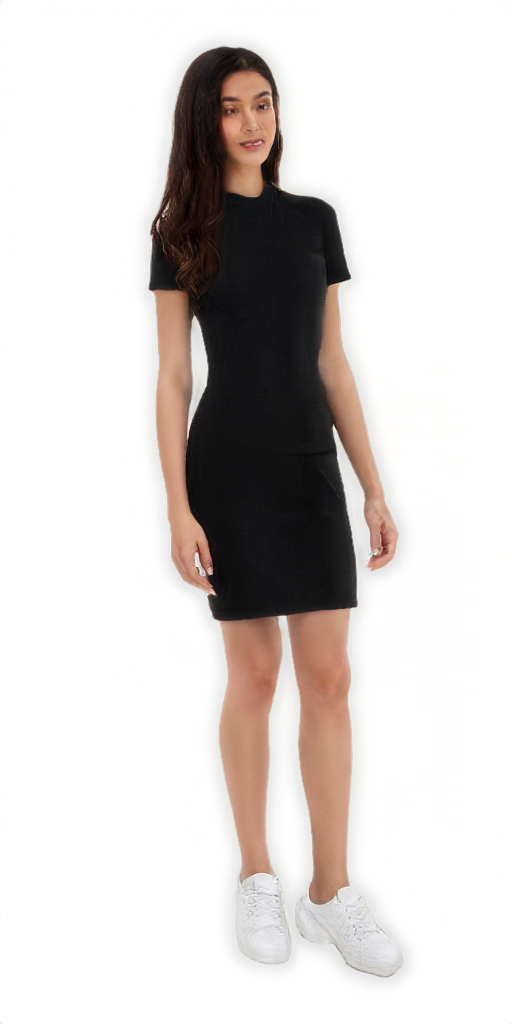

In [18]:
to_PIL(out_t[0])

In [26]:
des = tgt_desc[-1]
with torch.no_grad():
    ws, edited_videos = forward_triple(model, images.unsqueeze(0), inversions.unsqueeze(0), sampleT, [des])


Norm style: tensor(-0.4321, device='cuda:0') tensor(0.4321, device='cuda:0')
Norm Content: tensor(-0.8915, device='cuda:0') tensor(-0.0821, device='cuda:0')
Norm dynamics: tensor(0.4490, device='cuda:0') tensor(0.1083, device='cuda:0')
Norm style: tensor(0.0942, device='cuda:0') tensor(-1.0245, device='cuda:0')
Norm Content: tensor(-0.6031, device='cuda:0') tensor(-0.4736, device='cuda:0')
Norm dynamics: tensor(-0.0439, device='cuda:0') tensor(-0.0127, device='cuda:0')
Norm style: tensor(0.2434, device='cuda:0') tensor(-0.5948, device='cuda:0')
Norm Content: tensor(-0.2459, device='cuda:0') tensor(-0.4739, device='cuda:0')
Norm dynamics: tensor(-0.0619, device='cuda:0') tensor(0.0546, device='cuda:0')
Norm style: tensor(0.9002, device='cuda:0') tensor(-0.2130, device='cuda:0')
Norm Content: tensor(0.2688, device='cuda:0') tensor(1.0405, device='cuda:0')
Norm dynamics: tensor(0.7391, device='cuda:0') tensor(0.8715, device='cuda:0')
Norm style: tensor(1.1070, device='cuda:0') tensor(-0.8

In [27]:
edited_videos = edited_videos[0]

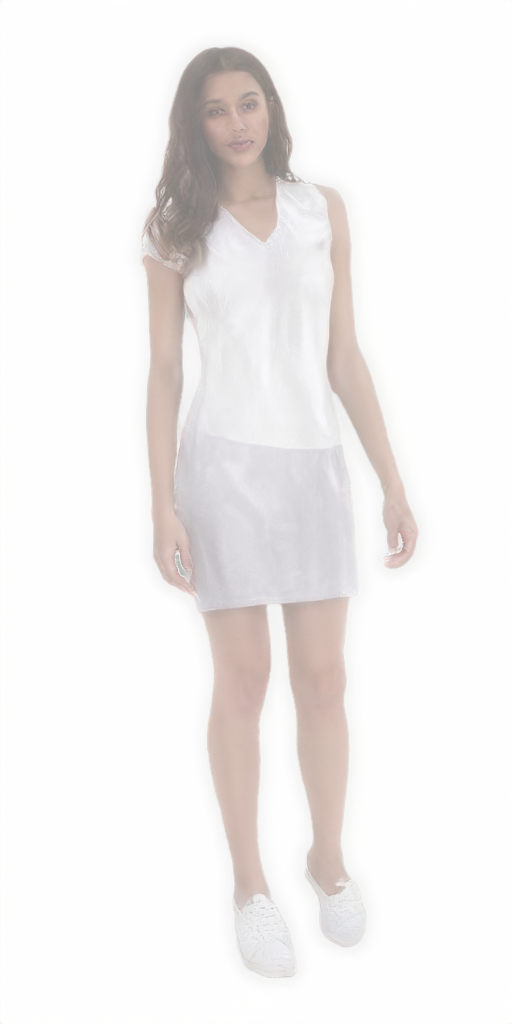

In [28]:
to_PIL(edited_videos[19])

In [31]:
ws.shape

torch.Size([20, 18, 512])

In [32]:
diff = ws[19] - ws[5]

In [35]:
diff.abs().sum(-1)

tensor([24.7657, 21.7472, 58.2117, 61.0191, 64.4686, 46.5964, 30.3736, 22.0080,
         3.5697,  3.5472,  5.3199,  1.6651,  2.8260,  2.5469,  1.7844,  2.2446,
         2.8007,  2.1804], device='cuda:0')

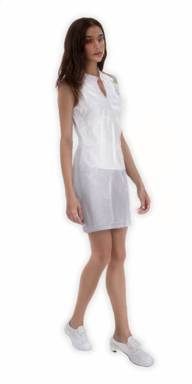

In [112]:
a = edited_videos[5] * 2 -1
to_PIL(a).resize((64*3, 128*3))

In [156]:
n = 8
tgt_w = ws[n].clone()
tgt_w[:n-1] = ws[19][:n-1]
# tgt_w[n-1][m1:m2] = ws[18][n-1][m1:m2]

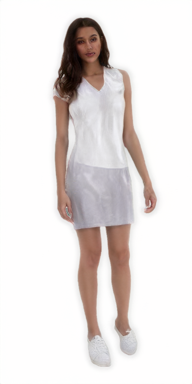

In [157]:
a = edited_videos[19] * 2 - 1
to_PIL(a).resize((64*3, 128*3))

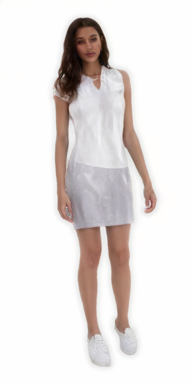

In [158]:
b = model.stylegan_G(tgt_w[None, :, :])[0]
to_PIL(b).resize((64*3, 128*3))

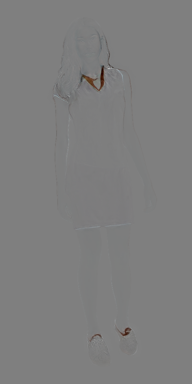

In [159]:
to_PIL(a-b).resize((64*3, 128*3))

In [71]:
# style, content, dynamic
n = 4

In [75]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_12.blending_gamma

Parameter containing:
tensor([0.0738], device='cuda:0', requires_grad=True)

In [76]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_12.blending_beta

Parameter containing:
tensor([0.0778], device='cuda:0', requires_grad=True)

In [77]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_gamma

Parameter containing:
tensor([0.0632], device='cuda:0', requires_grad=True)

In [79]:
model.style_mapper.medium_mapping.mapper.modulation_module_list[n].combine_modulation_r3.blending_beta

Parameter containing:
tensor([0.0684], device='cuda:0', requires_grad=True)

In [80]:
model.style_mapper.fine_mapping.mapper.modulation_module_list[n].combine_modulation.blending_gamma

Parameter containing:
tensor([0.0930], device='cuda:0', requires_grad=True)

In [81]:
model.style_mapper.fine_mapping.mapper.modulation_module_list[n].combine_modulation.blending_beta

Parameter containing:
tensor([0.1266], device='cuda:0', requires_grad=True)